In [1]:
import pystan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max_columns', 500)
az.style.use('arviz-darkgrid')

/Users/benjaminwee/anaconda/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('../data/raw/train.csv')

In [3]:
def z_std(x):
    z_score = (x - x.mean()) / x.std()
    return(z_score)

df['log_sales_price'] = np.log(df['SalePrice'])
df['log_lot_area'] = np.log(df['LotArea'])

df['log_sales_price_z'] = z_std(df[['log_sales_price']])
df['log_lot_area_z'] = z_std(df[['log_lot_area']])

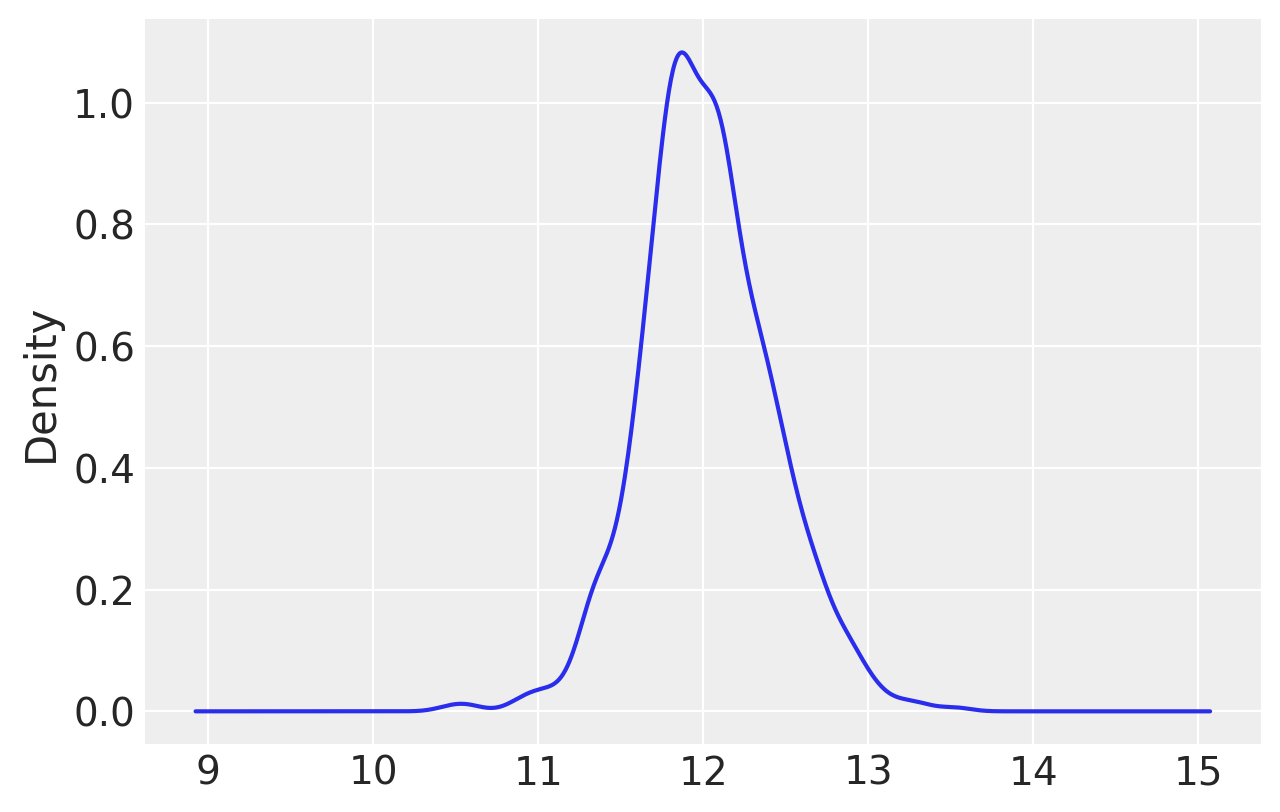

In [46]:
np.log(df['SalePrice']).plot.kde()

## Model Definition

Simple linear model. $log(LotArea)_i$ is standardised to mean zero and sd 1.

$$
log(SalesPrice)_i = \mu_i + \epsilon_i = \alpha + \beta * log(LotArea)_i + \epsilon_i \\
\epsilon\sim Normal(0, \sigma)
$$

In [22]:
linear_mod = '''
data {
    int N; // Number of rows
    vector[N] log_sales_price; // log sales price
    vector[N] log_lot_area_z; // log lot area
    real alpha_sd;
    real beta_sd;
    int<lower = 0, upper = 1> run_estimation; // Set to zero for prior predictive checks, set to one to evaluate likelihood
}
parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}
model {
    // Priors
    target += normal_lpdf(alpha | 0, alpha_sd);
    target += normal_lpdf(beta | 0, beta_sd);
    target += exponential_lpdf(sigma | 1);
    
    // Likelihood
    if(run_estimation==1){
        target += normal_lpdf(log_sales_price | alpha + beta * log_lot_area_z, sigma);

    }
}
generated quantities {
    vector[N] log_lik;
    vector[N] y_hat;
    
    for (n in 1:N){
          log_lik[n] = normal_lpdf(log_sales_price | alpha + beta * log_lot_area_z[n], sigma);
          y_hat[n] = normal_rng(alpha + beta * log_lot_area_z[n], sigma);
  }
    
}
'''

In [23]:
ols = pystan.StanModel(model_code=linear_mod)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4d802354be210678161bb84a6ed6cb45 NOW.


In [56]:
data = dict(N = len(df),
           log_sales_price = df['log_sales_price'],
           log_lot_area_z = df['log_lot_area_z'],
           alpha_sd = 1,
           beta_sd = 1,
           run_estimation = 1)

fit_ols = ols.sampling(data=data)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [48]:
az.summary(fit_ols, var_names=["alpha", "beta", "sigma"], credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,12.023,0.010,12.008,12.038,0.0,0.0,4609.0,4609.0,4607.0,3036.0,1.0
beta,0.160,0.009,0.145,0.174,0.0,0.0,4067.0,4042.0,4094.0,2640.0,1.0
sigma,0.367,0.007,0.356,0.378,0.0,0.0,4315.0,4311.0,4326.0,2858.0,1.0


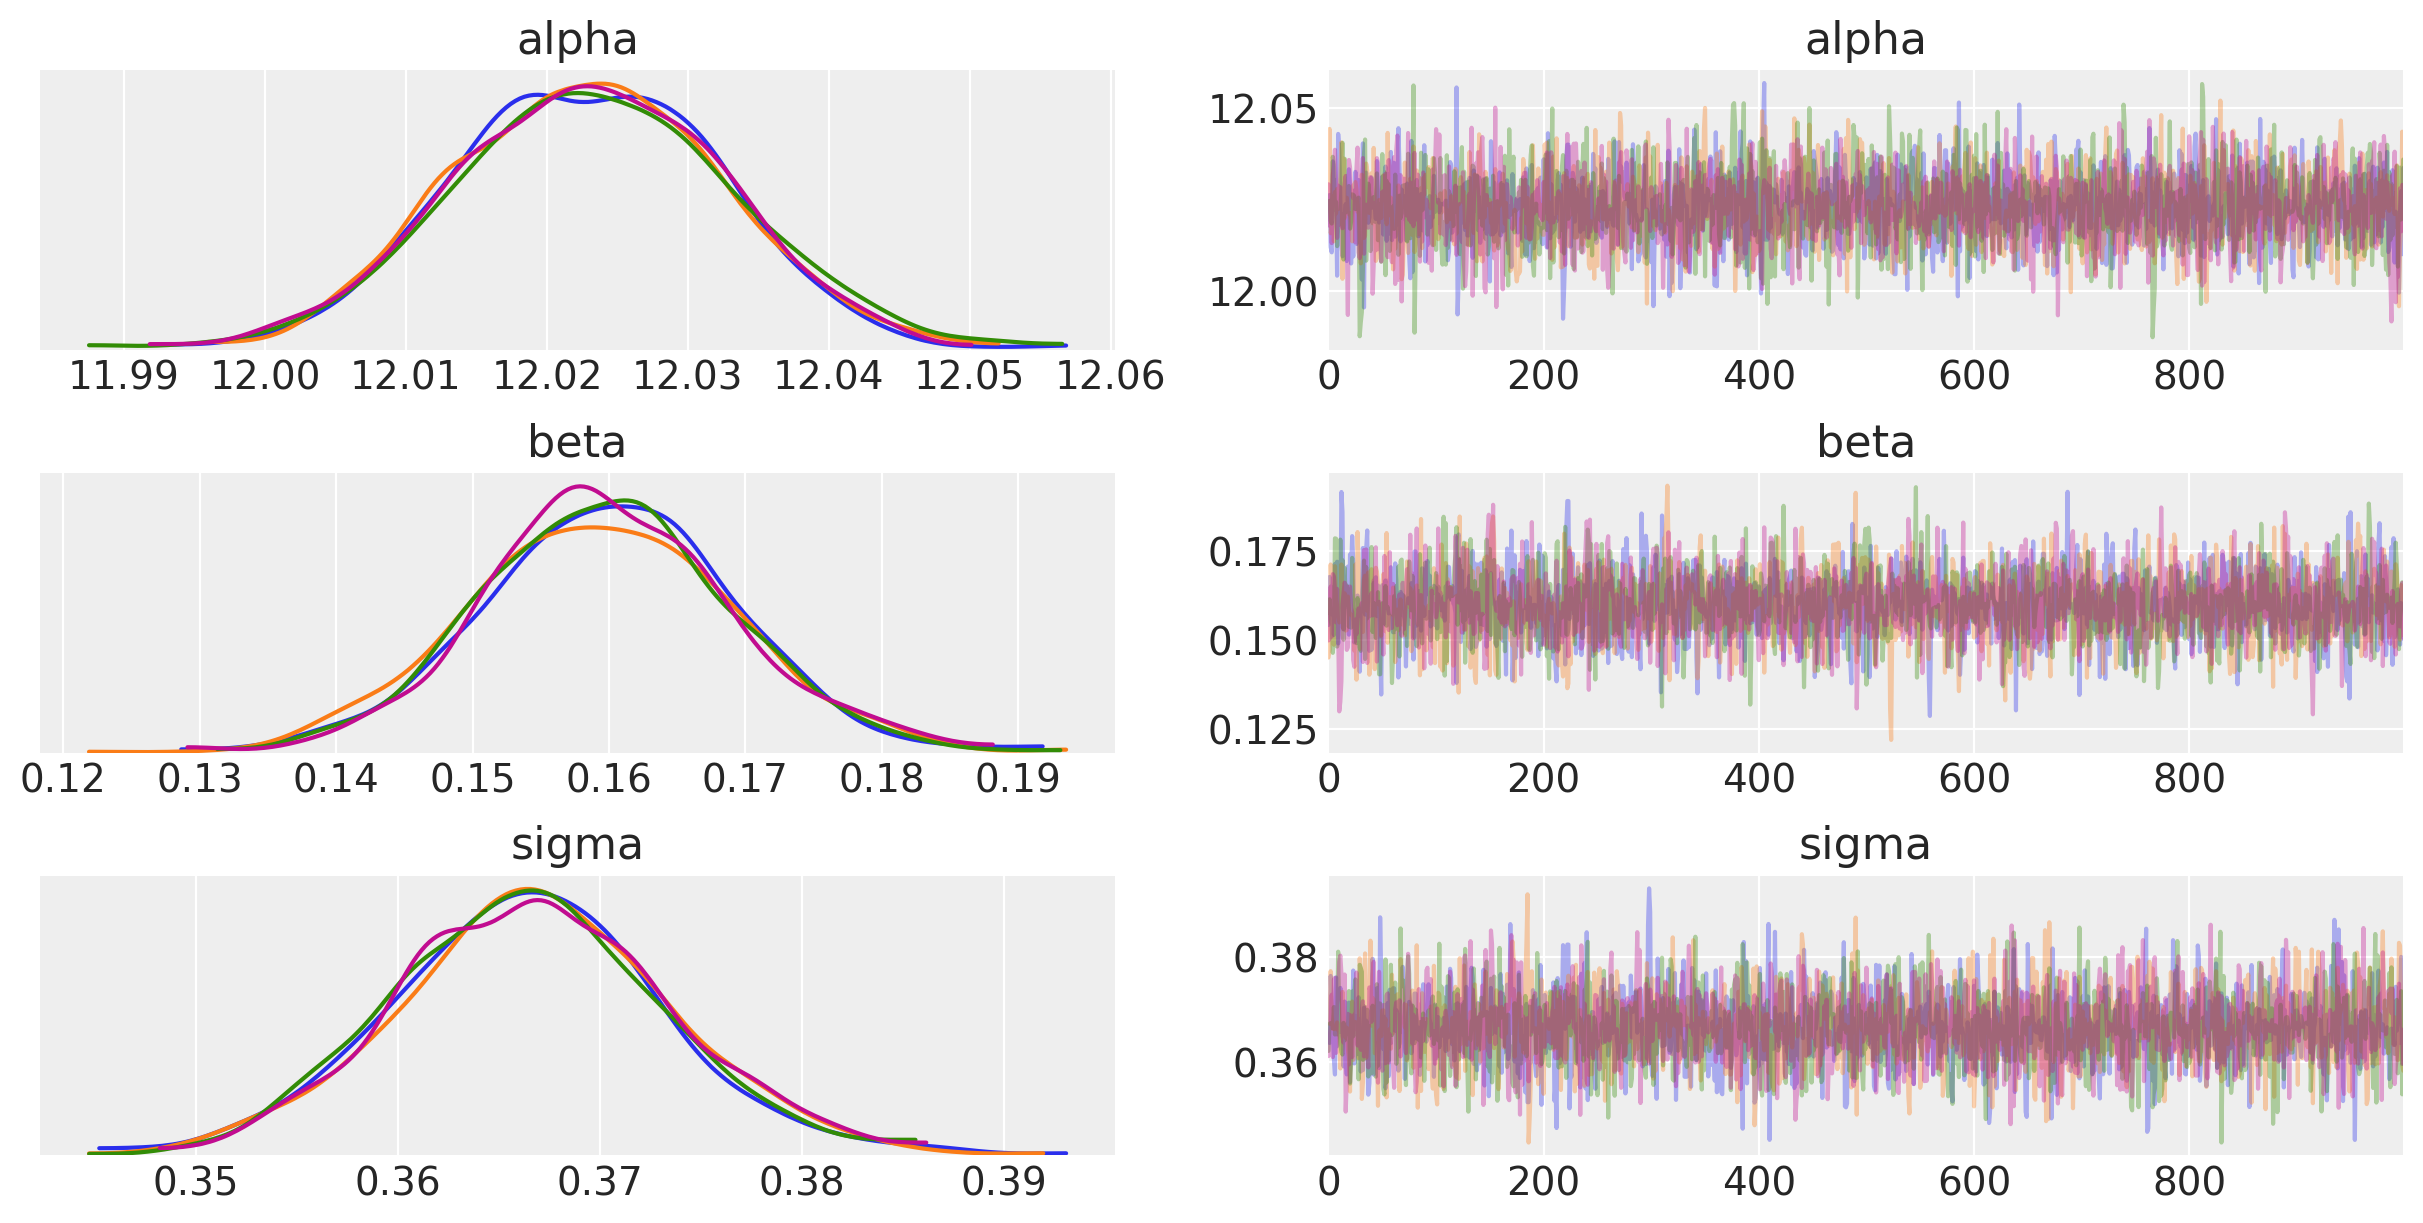

In [49]:
az.plot_trace(fit_ols, var_names=["alpha", "beta", "sigma"], compact = True);

In [50]:
ols_df = fit_ols.to_dataframe()

In [51]:
ols_df.filter(regex = 'y_hat').head()

,y_hat[1],y_hat[2],y_hat[3],y_hat[4],y_hat[5],y_hat[6],y_hat[7],y_hat[8],y_hat[9],y_hat[10],y_hat[11],y_hat[12],y_hat[13],y_hat[14],y_hat[15],y_hat[16],y_hat[17],y_hat[18],y_hat[19],y_hat[20],y_hat[21],y_hat[22],y_hat[23],y_hat[24],y_hat[25],y_hat[26],y_hat[27],y_hat[28],y_hat[29],y_hat[30],y_hat[31],y_hat[32],y_hat[33],y_hat[34],y_hat[35],y_hat[36],y_hat[37],y_hat[38],y_hat[39],y_hat[40],y_hat[41],y_hat[42],y_hat[43],y_hat[44],y_hat[45],y_hat[46],y_hat[47],y_hat[48],y_hat[49],y_hat[50],y_hat[51],y_hat[52],y_hat[53],y_hat[54],y_hat[55],y_hat[56],y_hat[57],y_hat[58],y_hat[59],y_hat[60],y_hat[61],y_hat[62],y_hat[63],y_hat[64],y_hat[65],y_hat[66],y_hat[67],y_hat[68],y_hat[69],y_hat[70],y_hat[71],y_hat[72],y_hat[73],y_hat[74],y_hat[75],y_hat[76],y_hat[77],y_hat[78],y_hat[79],y_hat[80],y_hat[81],y_hat[82],y_hat[83],y_hat[84],y_hat[85],y_hat[86],y_hat[87],y_hat[88],y_hat[89],y_hat[90],y_hat[91],y_hat[92],y_hat[93],y_hat[94],y_hat[95],y_hat[96],y_hat[97],y_hat[98],y_hat[99],y_hat[100],y_hat[101],y_hat[102],y_hat[103],y_hat[104],y_hat[105],y_hat[106],y_hat[107],y_hat[108],y_hat[109],y_hat[110],y_hat[111],y_hat[112],y_hat[113],y_hat[114],y_hat[115],y_hat[116],y_hat[117],y_hat[118],y_hat[119],y_hat[120],y_hat[121],y_hat[122],y_hat[123],y_hat[124],y_hat[125],y_hat[126],y_hat[127],y_hat[128],y_hat[129],y_hat[130],y_hat[131],y_hat[132],y_hat[133],y_hat[134],y_hat[135],y_hat[136],y_hat[137],y_hat[138],y_hat[139],y_hat[140],y_hat[141],y_hat[142],y_hat[143],y_hat[144],y_hat[145],y_hat[146],y_hat[147],y_hat[148],y_hat[149],y_hat[150],y_hat[151],y_hat[152],y_hat[153],y_hat[154],y_hat[155],y_hat[156],y_hat[157],y_hat[158],y_hat[159],y_hat[160],y_hat[161],y_hat[162],y_hat[163],y_hat[164],y_hat[165],y_hat[166],y_hat[167],y_hat[168],y_hat[169],y_hat[170],y_hat[171],y_hat[172],y_hat[173],y_hat[174],y_hat[175],y_hat[176],y_hat[177],y_hat[178],y_hat[179],y_hat[180],y_hat[181],y_hat[182],y_hat[183],y_hat[184],y_hat[185],y_hat[186],y_hat[187],y_hat[188],y_hat[189],y_hat[190],y_hat[191],y_hat[192],y_hat[193],y_hat[194],y_hat[195],y_hat[196],y_hat[197],y_hat[198],y_hat[199],y_hat[200],y_hat[201],y_hat[202],y_hat[203],y_hat[204],y_hat[205],y_hat[206],y_hat[207],y_hat[208],y_hat[209],y_hat[210],y_hat[211],y_hat[212],y_hat[213],y_hat[214],y_hat[215],y_hat[216],y_hat[217],y_hat[218],y_hat[219],y_hat[220],y_hat[221],y_hat[222],y_hat[223],y_hat[224],y_hat[225],y_hat[226],y_hat[227],y_hat[228],y_hat[229],y_hat[230],y_hat[231],y_hat[232],y_hat[233],y_hat[234],y_hat[235],y_hat[236],y_hat[237],y_hat[238],y_hat[239],y_hat[240],y_hat[241],y_hat[242],y_hat[243],y_hat[244],y_hat[245],y_hat[246],y_hat[247],y_hat[248],y_hat[249],y_hat[250],...,y_hat[1211],y_hat[1212],y_hat[1213],y_hat[1214],y_hat[1215],y_hat[1216],y_hat[1217],y_hat[1218],y_hat[1219],y_hat[1220],y_hat[1221],y_hat[1222],y_hat[1223],y_hat[1224],y_hat[1225],y_hat[1226],y_hat[1227],y_hat[1228],y_hat[1229],y_hat[1230],y_hat[1231],y_hat[1232],y_hat[1233],y_hat[1234],y_hat[1235],y_hat[1236],y_hat[1237],y_hat[1238],y_hat[1239],y_hat[1240],y_hat[1241],y_hat[1242],y_hat[1243],y_hat[1244],y_hat[1245],y_hat[1246],y_hat[1247],y_hat[1248],y_hat[1249],y_hat[1250],y_hat[1251],y_hat[1252],y_hat[1253],y_hat[1254],y_hat[1255],y_hat[1256],y_hat[1257],y_hat[1258],y_hat[1259],y_hat[1260],y_hat[1261],y_hat[1262],y_hat[1263],y_hat[1264],y_hat[1265],y_hat[1266],y_hat[1267],y_hat[1268],y_hat[1269],y_hat[1270],y_hat[1271],y_hat[1272],y_hat[1273],y_hat[1274],y_hat[1275],y_hat[1276],y_hat[1277],y_hat[1278],y_hat[1279],y_hat[1280],y_hat[1281],y_hat[1282],y_hat[1283],y_hat[1284],y_hat[1285],y_hat[1286],y_hat[1287],y_hat[1288],y_hat[1289],y_hat[1290],y_hat[1291],y_hat[1292],y_hat[1293],y_hat[1294],y_hat[1295],y_hat[1296],y_hat[1297],y_hat[1298],y_hat[1299],y_hat[1300],y_hat[1301],y_hat[1302],y_hat[1303],y_hat[1304],y_hat[1305],y_hat[1306],y_hat[1307],y_hat[1308],y_hat[1309],y_hat[1310],y_hat[1311],y_hat[1312],y_hat[1313],y_hat[1314],y_hat[1315],y_hat[1316],y_hat[1317],y_hat[1318],y_hat[1319],y_hat[1320],y_hat[1321],y_hat[1322],y_hat[132

In [52]:
# Summarise variation of each value
ols_df.filter(regex='y_hat').describe()

,y_hat[1],y_hat[2],y_hat[3],y_hat[4],y_hat[5],y_hat[6],y_hat[7],y_hat[8],y_hat[9],y_hat[10],y_hat[11],y_hat[12],y_hat[13],y_hat[14],y_hat[15],y_hat[16],y_hat[17],y_hat[18],y_hat[19],y_hat[20],y_hat[21],y_hat[22],y_hat[23],y_hat[24],y_hat[25],y_hat[26],y_hat[27],y_hat[28],y_hat[29],y_hat[30],y_hat[31],y_hat[32],y_hat[33],y_hat[34],y_hat[35],y_hat[36],y_hat[37],y_hat[38],y_hat[39],y_hat[40],y_hat[41],y_hat[42],y_hat[43],y_hat[44],y_hat[45],y_hat[46],y_hat[47],y_hat[48],y_hat[49],y_hat[50],y_hat[51],y_hat[52],y_hat[53],y_hat[54],y_hat[55],y_hat[56],y_hat[57],y_hat[58],y_hat[59],y_hat[60],y_hat[61],y_hat[62],y_hat[63],y_hat[64],y_hat[65],y_hat[66],y_hat[67],y_hat[68],y_hat[69],y_hat[70],y_hat[71],y_hat[72],y_hat[73],y_hat[74],y_hat[75],y_hat[76],y_hat[77],y_hat[78],y_hat[79],y_hat[80],y_hat[81],y_hat[82],y_hat[83],y_hat[84],y_hat[85],y_hat[86],y_hat[87],y_hat[88],y_hat[89],y_hat[90],y_hat[91],y_hat[92],y_hat[93],y_hat[94],y_hat[95],y_hat[96],y_hat[97],y_hat[98],y_hat[99],y_hat[100],y_hat[101],y_hat[102],y_hat[103],y_hat[104],y_hat[105],y_hat[106],y_hat[107],y_hat[108],y_hat[109],y_hat[110],y_hat[111],y_hat[112],y_hat[113],y_hat[114],y_hat[115],y_hat[116],y_hat[117],y_hat[118],y_hat[119],y_hat[120],y_hat[121],y_hat[122],y_hat[123],y_hat[124],y_hat[125],y_hat[126],y_hat[127],y_hat[128],y_hat[129],y_hat[130],y_hat[131],y_hat[132],y_hat[133],y_hat[134],y_hat[135],y_hat[136],y_hat[137],y_hat[138],y_hat[139],y_hat[140],y_hat[141],y_hat[142],y_hat[143],y_hat[144],y_hat[145],y_hat[146],y_hat[147],y_hat[148],y_hat[149],y_hat[150],y_hat[151],y_hat[152],y_hat[153],y_hat[154],y_hat[155],y_hat[156],y_hat[157],y_hat[158],y_hat[159],y_hat[160],y_hat[161],y_hat[162],y_hat[163],y_hat[164],y_hat[165],y_hat[166],y_hat[167],y_hat[168],y_hat[169],y_hat[170],y_hat[171],y_hat[172],y_hat[173],y_hat[174],y_hat[175],y_hat[176],y_hat[177],y_hat[178],y_hat[179],y_hat[180],y_hat[181],y_hat[182],y_hat[183],y_hat[184],y_hat[185],y_hat[186],y_hat[187],y_hat[188],y_hat[189],y_hat[190],y_hat[191],y_hat[192],y_hat[193],y_hat[194],y_hat[195],y_hat[196],y_hat[197],y_hat[198],y_hat[199],y_hat[200],y_hat[201],y_hat[202],y_hat[203],y_hat[204],y_hat[205],y_hat[206],y_hat[207],y_hat[208],y_hat[209],y_hat[210],y_hat[211],y_hat[212],y_hat[213],y_hat[214],y_hat[215],y_hat[216],y_hat[217],y_hat[218],y_hat[219],y_hat[220],y_hat[221],y_hat[222],y_hat[223],y_hat[224],y_hat[225],y_hat[226],y_hat[227],y_hat[228],y_hat[229],y_hat[230],y_hat[231],y_hat[232],y_hat[233],y_hat[234],y_hat[235],y_hat[236],y_hat[237],y_hat[238],y_hat[239],y_hat[240],y_hat[241],y_hat[242],y_hat[243],y_hat[244],y_hat[245],y_hat[246],y_hat[247],y_hat[248],y_hat[249],y_hat[250],...,y_hat[1211],y_hat[1212],y_hat[1213],y_hat[1214],y_hat[1215],y_hat[1216],y_hat[1217],y_hat[1218],y_hat[1219],y_hat[1220],y_hat[1221],y_hat[1222],y_hat[1223],y_hat[1224],y_hat[1225],y_hat[1226],y_hat[1227],y_hat[1228],y_hat[1229],y_hat[1230],y_hat[1231],y_hat[1232],y_hat[1233],y_hat[1234],y_hat[1235],y_hat[1236],y_hat[1237],y_hat[1238],y_hat[1239],y_hat[1240],y_hat[1241],y_hat[1242],y_hat[1243],y_hat[1244],y_hat[1245],y_hat[1246],y_hat[1247],y_hat[1248],y_hat[1249],y_hat[1250],y_hat[1251],y_hat[1252],y_hat[1253],y_hat[1254],y_hat[1255],y_hat[1256],y_hat[1257],y_hat[1258],y_hat[1259],y_hat[1260],y_hat[1261],y_hat[1262],y_hat[1263],y_hat[1264],y_hat[1265],y_hat[1266],y_hat[1267],y_hat[1268],y_hat[1269],y_hat[1270],y_hat[1271],y_hat[1272],y_hat[1273],y_hat[1274],y_hat[1275],y_hat[1276],y_hat[1277],y_hat[1278],y_hat[1279],y_hat[1280],y_hat[1281],y_hat[1282],y_hat[1283],y_hat[1284],y_hat[1285],y_hat[1286],y_hat[1287],y_hat[1288],y_hat[1289],y_hat[1290],y_hat[1291],y_hat[1292],y_hat[1293],y_hat[1294],y_hat[1295],y_hat[1296],y_hat[1297],y_hat[1298],y_hat[1299],y_hat[1300],y_hat[1301],y_hat[1302],y_hat[1303],y_hat[1304],y_hat[1305],y_hat[1306],y_hat[1307],y_hat[1308],y_hat[1309],y_hat[1310],y_hat[1311],y_hat[1312],y_hat[1313],y_hat[1314],y_hat[1315],y_hat[1316],y_hat[1317],y_hat[1318],y_hat[1319],y_hat[1320],y_hat[1321],y_hat[1322],y_hat[132

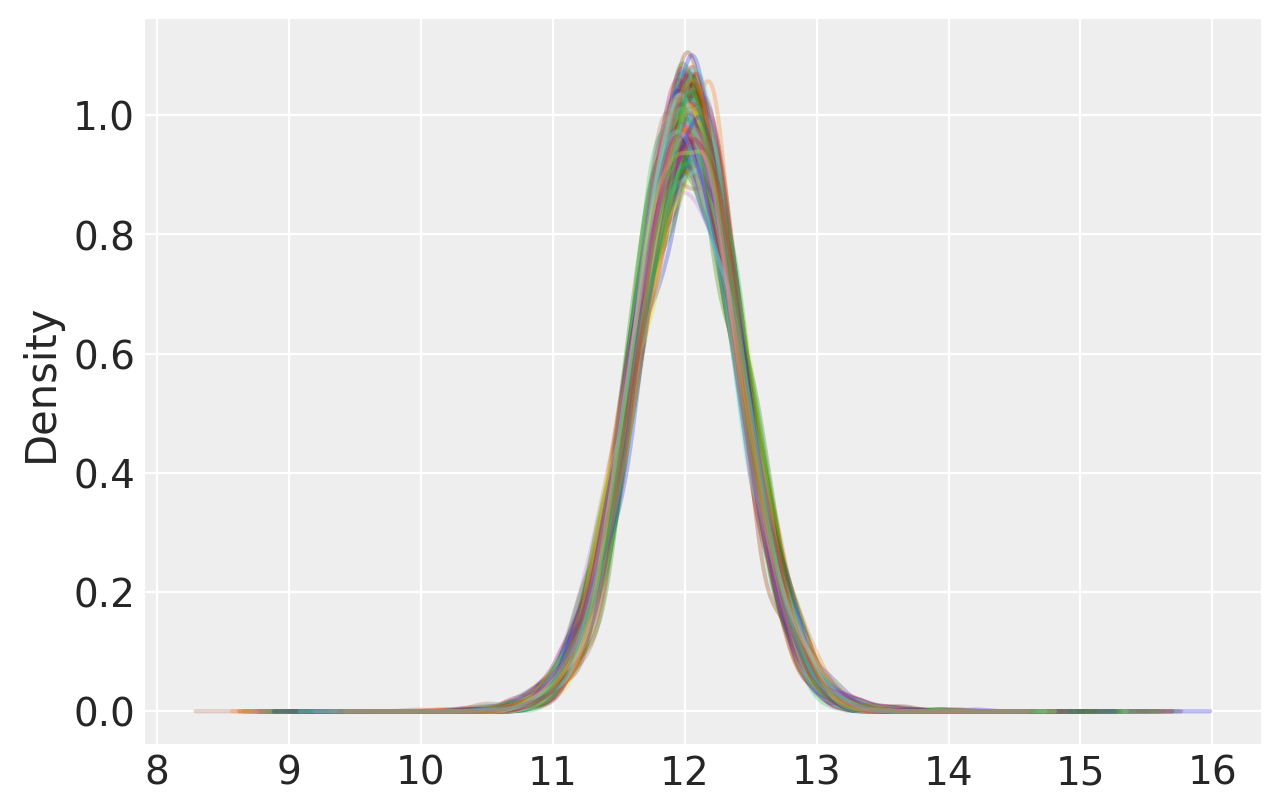

In [57]:
ols_df.filter(regex = 'y_hat').T.iloc[:, :500].plot.kde(alpha=0.3,
                                                        legend = False,
                                                        xlim = (-5, 5));

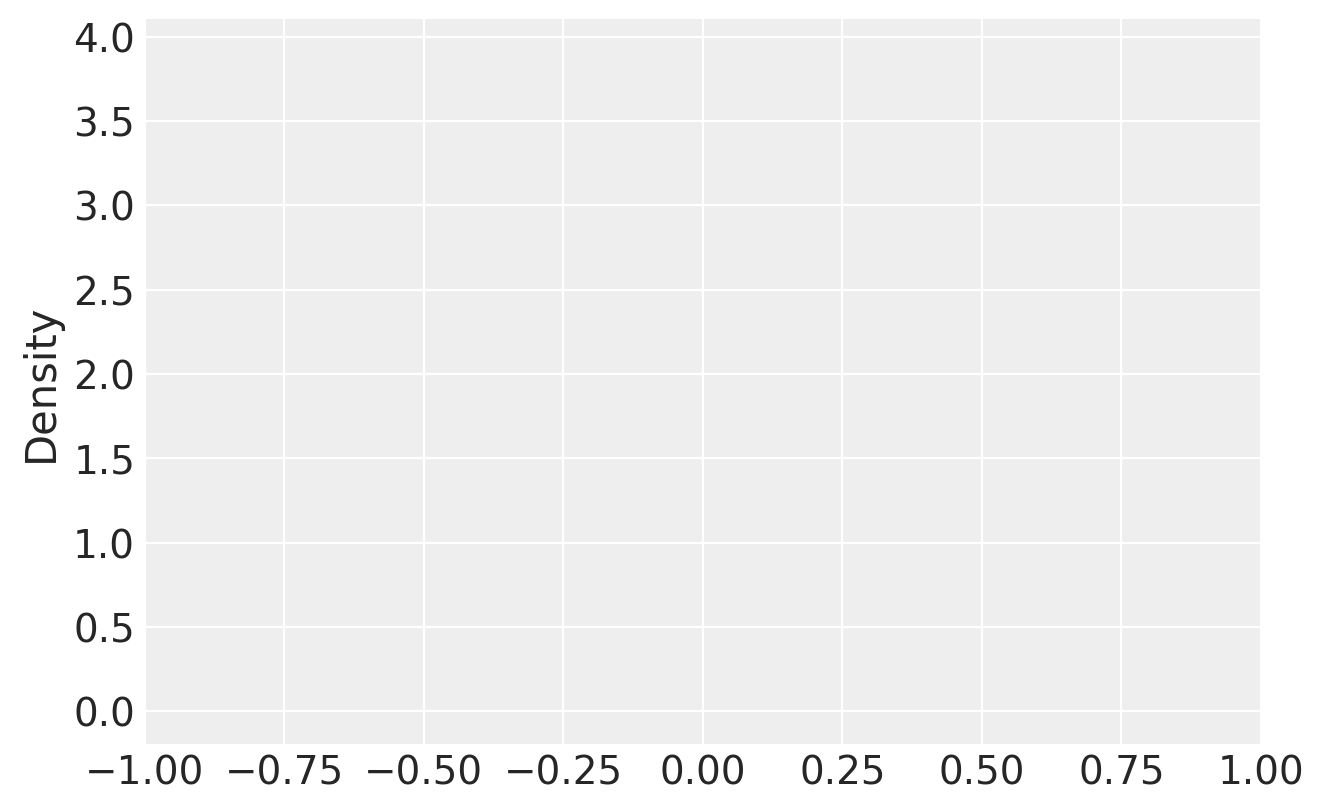

In [54]:
ols_df.filter(regex = 'y_hat').T.mean(axis=1).plot.kde(legend = False,
                                                        xlim = (-1, 1));

In [55]:
np.exp(ols_df.filter(regex = 'y_hat').T.mean(axis=1))

y_hat[1]       161721.532307
y_hat[2]       170390.536768
y_hat[3]       178201.397511
y_hat[4]       168928.960210
y_hat[5]       193314.576864
                   ...      
y_hat[1456]    161043.872996
y_hat[1457]    187518.361582
y_hat[1458]    164181.626880
y_hat[1459]    169722.614342
y_hat[1460]    170203.658465
Length: 1460, dtype: float64